Device : cuda:0
(100,) (20, 100, 1)


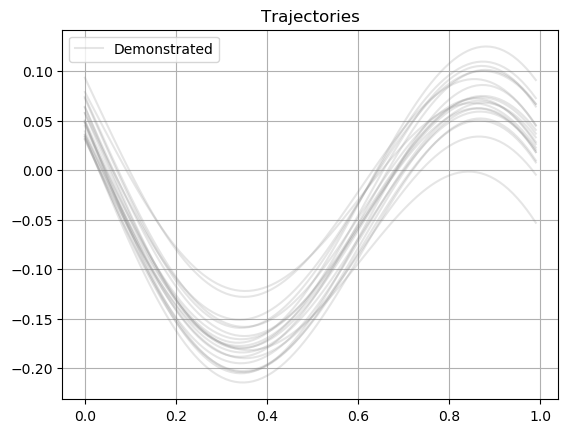

In [2]:
import numpy as np
from movement_primitives.dmp import DMP
from movement_primitives.dmp._dmp import *
import matplotlib.pyplot as plt

import sys
import torch
import time, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)
    

from cnmp import CNMP

from data_generators import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

x = np.arange(0,1.00,0.01)
nrTraj=20
sigmaNoise=0.02

A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x)))))
Y = np.zeros((nrTraj, len(x)))

for traj in range(nrTraj):
    sample = -np.dot(A + sigmaNoise * np.random.randn(1,4), X)[0]
    Y[traj] = sample
    label = 'Demonstrated' if traj==0 else ''
    plt.plot(x, sample, 'gray', label=label, alpha=0.2)

plt.legend()
plt.grid()
plt.title('Trajectories')

Y = np.expand_dims(Y, -1)
print(x.shape, Y.shape)

In [3]:
dx, dy = 1, 1
num_trajs, num_steps, num_dims = Y.shape
num_demos = int(num_trajs*.8)  # 80% of the data is used for training
num_test = num_trajs - num_demos
t_steps = num_steps

n_max, m_max = 10, 10

In [4]:
dt = 1/num_steps
dz = dx  # Right?

d = DMP(n_dims=num_dims, n_weights_per_dim=6, dt=dt)
d.imitate(x, Y[0])

forcing_terms = np.zeros_like(Y)
phases = np.zeros((num_trajs, num_steps, dz))

for i in range(num_trajs):
    d.imitate(x, Y[i])
    for j, t in enumerate(np.arange(0, 1, dt)):
        z = d.forcing_term.phase(t)  # Calculate the phase
        phases[i, j] = z
        forcing_terms[i, j] = d.forcing_term.forcing_term(z).squeeze()
    d.reset()

y_train, y_test = torch.from_numpy(forcing_terms[:num_demos]), torch.from_numpy(forcing_terms[num_demos:])
x_train, x_test = torch.from_numpy(phases[:num_demos]), torch.from_numpy(phases[num_demos:])

y_train, y_test = (y_train/1000).to(device), (y_test/1000).to(device)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([16, 100, 1]) torch.Size([16, 100, 1])
torch.Size([4, 100, 1]) torch.Size([4, 100, 1])


In [5]:
batch_size = 1

model_ = CNMP(input_dim=dx, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=[64, 64], decoder_hidden_dims=[64, 64], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=model_.parameters())

pytorch_total_params = sum(p.numel() for p in model_.parameters())
print(pytorch_total_params)


if torch.__version__ >= "2.0":
    model = torch.compile(model_)
else:
    model = model_

8706


In [6]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = x_train[traj_id, n_ids]
        obs[i, :n, dx:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dx] = x_train[traj_id, m_ids]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        if fixed_ind != None:
            n_ids[-1] = fixed_ind
        
        val_obs[i, :n, :dx] = x_test[traj_id, n_ids]
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dx] = x_test[traj_id]
        val_tar_y[i] = traj[m_ids]

In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/force/cnmp/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 500_000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_test//batch_size
avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0
loss_report_interval = 500
val_per_epoch = 1000
min_val_loss, min_val_loss1, min_val_loss_cnmp = 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_test = True

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()
        
        pred = model(obs, tar_x, obs_mask)

        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_test)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_test, v_traj_ids[j])
                pred = model.val(val_obs, val_tar_x, val_obs_mask)
                if plot_test:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}test_{epoch}_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :model.output_dim], val_tar_y).item()

            val_loss /= v_epoch_iter
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/best_cnmp.pt')

    epoch_loss /= epoch_iter
    avg_loss += epoch_loss

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss / loss_report_interval))
        avg_loss = 0

Epoch: 0, Loss: 0.001115617610514164
Epoch: 500, Loss: -2.7799610440141405
New best: 0.00020330859842943028
Epoch: 1000, Loss: -2.931056233800948
Epoch: 1500, Loss: -3.3784536728113888
New best: 2.77817766800581e-05
Epoch: 2000, Loss: -3.601884428070858
Epoch: 2500, Loss: -3.688424466684461
Epoch: 3000, Loss: -3.754493109226227
Epoch: 3500, Loss: -4.174403804007918
New best: 9.116730325331446e-06
Epoch: 4000, Loss: -4.566429497270379
Epoch: 4500, Loss: -4.66967860622704
New best: 2.181700949677179e-06
Epoch: 5000, Loss: -4.798326018741355
Epoch: 5500, Loss: -4.843960363741964
Epoch: 6000, Loss: -4.902757752272068
Epoch: 6500, Loss: -4.946005748338997
New best: 9.000315799312375e-07
Epoch: 7000, Loss: -4.984199622675776
Epoch: 7500, Loss: -4.987873468785547
Epoch: 8000, Loss: -5.024422802263405
Epoch: 8500, Loss: -5.079041328039952
Epoch: 9000, Loss: -5.108647339339601
Epoch: 9500, Loss: -5.123897319304874
Epoch: 10000, Loss: -5.124779366983101
Epoch: 10500, Loss: -5.146349512478337
Epo

<Figure size 640x480 with 0 Axes>

0.0 0.01 [0.09456567] [0.] [0.03604701] [0.] [0.] [0.09456567] [0.] [0.] 1.0 0.0 25.0 6.25 <movement_primitives.dmp._forcing_term.ForcingTerm object at 0x7f42a75a22e0> None 0.001 False
0.01 0.02 [0.09342431] [-0.22283015] [0.03604701] [0.] [0.] [0.09456567] [0.] [0.] 1.0 0.0 25.0 6.25 <movement_primitives.dmp._forcing_term.ForcingTerm object at 0x7f42a75a22e0> None 0.001 False
0.02 0.03 [0.09021523] [-0.41375578] [0.03604701] [0.] [0.] [0.09456567] [0.] [0.] 1.0 0.0 25.0 6.25 <movement_primitives.dmp._forcing_term.ForcingTerm object at 0x7f42a75a22e0> None 0.001 False
0.03 0.04 [0.08525127] [-0.57400998] [0.03604701] [0.] [0.] [0.09456567] [0.] [0.] 1.0 0.0 25.0 6.25 <movement_primitives.dmp._forcing_term.ForcingTerm object at 0x7f42a75a22e0> None 0.001 False
0.04 0.05 [0.07883273] [-0.70490595] [0.03604701] [0.] [0.] [0.09456567] [0.] [0.] 1.0 0.0 25.0 6.25 <movement_primitives.dmp._forcing_term.ForcingTerm object at 0x7f42a75a22e0> None 0.001 False
0.05 0.06 [0.07124573] [-0.80798366

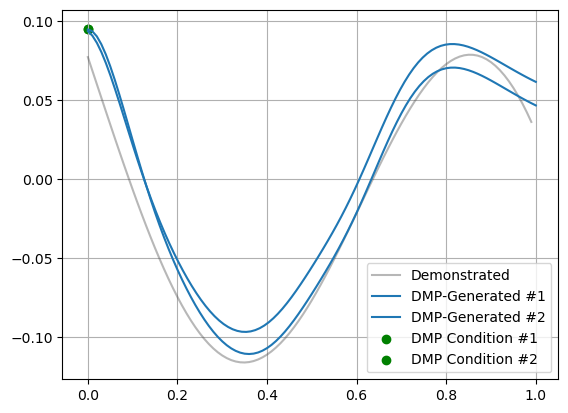

In [7]:
from copy import deepcopy

start = Y[1][0]
plt.scatter(0, start, color='green', label='DMP Condition #1')

d_ = deepcopy(d)
d_.configure(start_y=start)
n_step = 0

current_y = np.array([start]).reshape(n_dims,)
current_yd = np.array([0.]).reshape(n_dims,)

goal_y = np.array([Y[1][-1]]).reshape(n_dims,)

start_y = np.array([start]).reshape(n_dims,)
start_yd = goal_yd = np.array([0.]).reshape(n_dims,)
start_ydd = goal_ydd = np.array([0.]).reshape(n_dims,)

T = np.arange(0, 1+dt, dt)

traj1 = np.zeros(100)

while n_step<n_steps:

    modified_dmp_step_rk4(T[n_step], T[n_step+1], current_y, current_yd, goal_y, goal_yd, goal_ydd, 
                          start_y, start_yd, start_ydd, 1.0, 0.0, 25.0, 6.25, 
                          d_.forcing_term, forces=None)
    
    traj1[n_step] = current_y
    n_step += 1

Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigit
Yigi

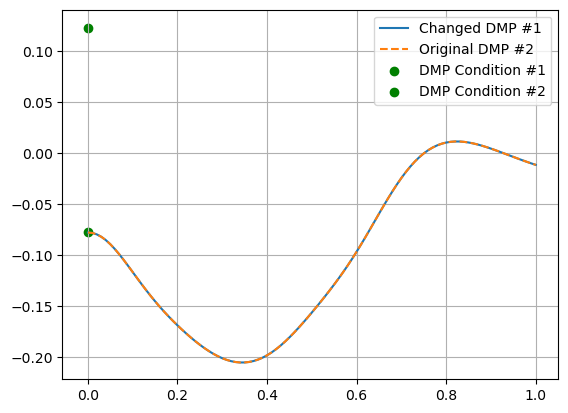

In [5]:
new_fs = forcing_term_values

new_fs+=np.random.rand(*new_fs.shape)*1000
d_ = deepcopy(d)
d_.forcing_term.weights = new_fs

start = Y[0][0] - 0.1
plt.scatter(0, start, color='green', label='DMP Condition #1')

d_.configure(start_y=start)
t, traj1_ = d_.open_loop()
p = plt.plot(t, traj1_.squeeze(), label='Changed DMP #1')

start = Y[0][0] + 0.1
plt.scatter(0, start, color='green', label='DMP Condition #2')

d_.configure(start_y=start)
t, traj2_ = d_.open_loop()
# plt.plot(t, traj2_.squeeze(), color=p[0].get_color(), label='Changed DMP #2', alpha=0.5)
p = plt.plot(t, traj1.squeeze(), label='Original DMP #2', linestyle='--')
# plt.plot(t, traj2.squeeze(), color=p[0].get_color(), label='Original DMP #2')

plt.legend()
plt.grid()

In [6]:
for i in range(100):
    print(traj1[i], traj1_[i])

[-0.07783284] [-0.07783284]
[-0.07829667] [-0.07829667]
[-0.07970998] [-0.07970998]
[-0.0820622] [-0.0820622]
[-0.08529434] [-0.08529434]
[-0.08931086] [-0.08931086]
[-0.09399119] [-0.09399119]
[-0.09920044] [-0.09920044]
[-0.10479897] [-0.10479897]
[-0.11065052] [-0.11065052]
[-0.11662902] [-0.11662902]
[-0.12262391] [-0.12262391]
[-0.12854397] [-0.12854397]
[-0.13431957] [-0.13431957]
[-0.13990308] [-0.13990308]
[-0.14526763] [-0.14526763]
[-0.1504041] [-0.1504041]
[-0.15531691] [-0.15531691]
[-0.16001901] [-0.16001901]
[-0.1645267] [-0.1645267]
[-0.16885504] [-0.16885504]
[-0.17301424] [-0.17301424]
[-0.17700738] [-0.17700738]
[-0.18082946] [-0.18082946]
[-0.18446763] [-0.18446763]
[-0.18790235] [-0.18790235]
[-0.19110902] [-0.19110902]
[-0.19405995] [-0.19405995]
[-0.19672606] [-0.19672606]
[-0.1990785] [-0.1990785]
[-0.20108972] [-0.20108972]
[-0.20273424] [-0.20273424]
[-0.20398899] [-0.20398899]
[-0.20483352] [-0.20483352]
[-0.2052501] [-0.2052501]
[-0.205224] [-0.205224]
[-0.20